In [ ]:
# drive dosya erişim
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Kütüphanleri indir
#!pip install tensorflow
#!pip install keras

In [ ]:
from keras.models import Sequential#sirali modeldir
from keras.layers import Dropout, Dense, BatchNormalization, GlobalAveragePooling2D#katmanlar bunlar olacak
from tensorflow.keras.preprocessing.image import ImageDataGenerator#, img_to_array, load_img#veri on islemede kullanilir
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from keras.metrics import Precision, Recall

In [ ]:
precision = Precision()
recall = Recall()

classes_names = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

In [ ]:
# Veri setinin yolu
train_data_dir = r"/content/drive/MyDrive/proje-b_dataset/train"
test_data_dir = r"/content/drive/MyDrive/proje-b_dataset/test"
valid_data_dir = r"/content/drive/MyDrive/proje-b_dataset/validation"

In [ ]:
# Veri ön işleme ve augmentasyon için ImageDataGenerator kullanma
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.5], # Kontrast ve parlaklık ayarı
    width_shift_range=0.15,  # Yatay kaydırma
    height_shift_range=0.15,  # Dikey kaydırma
    zoom_range=0.1,  # Ölçeklendirme
    channel_shift_range=10.0  # Düşük yoğunluklu Gaussian gürültü
    )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Eğitim veri setini yükleyin
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical' # Çoklu sınıf için categorical kullanılacak

)

Found 1890 images belonging to 14 classes.


In [ ]:
# Doğrulama veri setini yükleyin
validation_generator = validation_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical'

)

Found 420 images belonging to 14 classes.


In [ ]:
# Test veri setini yükleyin
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical'
)


Found 406 images belonging to 14 classes.


In [ ]:
#VGG MODEL
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg)
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes_names), activation="softmax"))
print(model.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 400)               205200    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                         

In [ ]:
# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

#Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)#egitim esnasinda ogrenme oranini dinamik olarak ayarlar

# Model Checkpoint
checkpoint = ModelCheckpoint('best_model_vgg16.h5', verbose=1, save_best_only=True, monitor='val_loss')#model egitimi esnasinda en iyi genelleme yapan agirliklari kaydeder


In [ ]:
# Modeli eğitin
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    batch_size=128,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 1.3312 - accuracy: 0.5825 - precision: 0.7640 - recall: 0.4899 
Epoch 1: val_loss improved from inf to 0.98849, saving model to best_model_vgg16.h5
15/15 [==============================] - 684s 45s/step - loss: 1.3312 - accuracy: 0.5825 - precision: 0.7640 - recall: 0.4899 - val_loss: 0.9885 - val_accuracy: 0.7786 - val_precision: 0.9882 - val_recall: 0.3976 - lr: 0.0100
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.8148 - precision: 0.8664 - recall: 0.7825 
Epoch 2: val_loss improved from 0.98849 to 0.89328, saving model to best_model_vgg16.h5
15/15 [==============================] - 498s 33s/step - loss: 0.5612 - accuracy: 0.8148 - precision: 0.8664 - recall: 0.7825 - val_loss: 0.8933 - val_accuracy: 0.7190 - val_precision: 0.8406 - val_recall: 0.5024 - lr: 0.0100
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.8519 - precision: 0.8950 - recall: 0.8159 
Epoch 3: val_loss improved from 0.89328 to 0.66743, saving model to best_model_vgg16.h5
15/15 [==============================] - 489s 33s/step - loss: 0.4324 - accuracy: 0.8519 - precision: 0.8950 - recall: 0.8159 - val_loss: 0.6674 - val_accuracy: 0.7714 - val_precision: 0.9016 - val_recall: 0.6762 - lr: 0.0100
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8794 - precision: 0.9067 - r

In [ ]:
# Model performansını değerlendirme
evaluation = model.evaluate((test_generator), steps=len(test_generator))
print("Test veri seti üzerinde modelin performansı: Loss={}, Accuracy={}, Precision={}, Recall={}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3]))


4/4 [==============================] - 108s 27s/step - loss: 0.0360 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9901
Test veri seti üzerinde modelin performansı: Loss=0.035991545766592026, Accuracy=0.9926108121871948, Precision=0.9925925731658936, Recall=0.9901477694511414


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


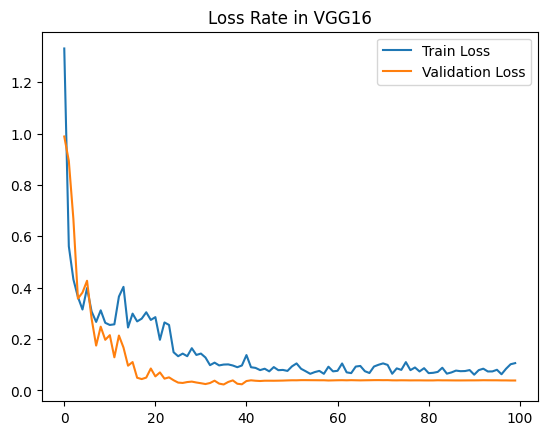

In [ ]:
#result visualize
import matplotlib.pyplot as plt
print(history.history.keys())
plt.title("Loss Rate in VGG16")
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

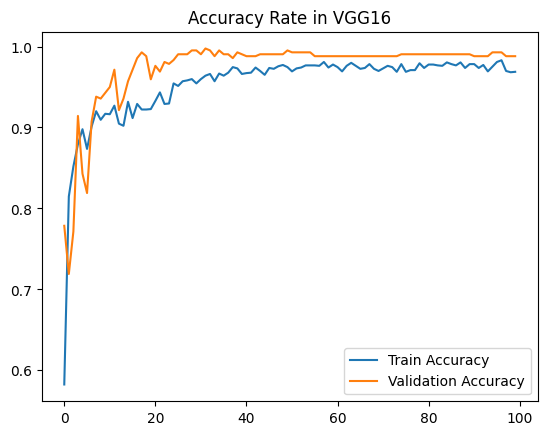

In [ ]:
plt.figure()
plt.title("Accuracy Rate in VGG16")
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

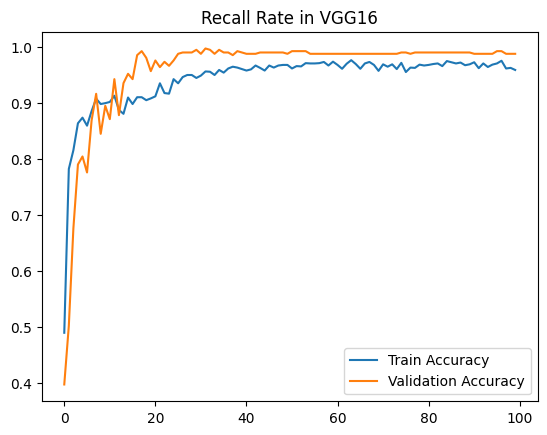

In [ ]:
plt.figure()
plt.title("Recall Rate in VGG16")
plt.plot(history.history["recall"], label = "Train Accuracy")
plt.plot(history.history["val_recall"], label = "Validation Accuracy")
plt.legend()
plt.show()

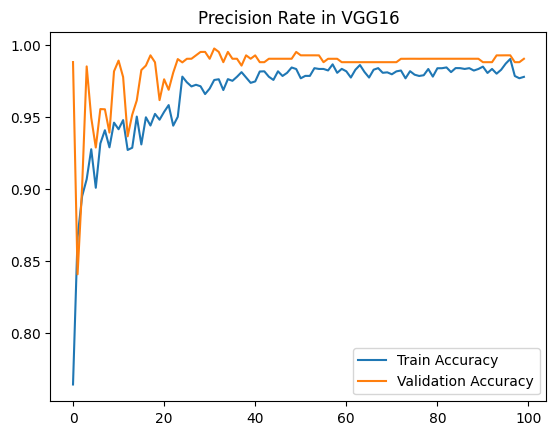

In [ ]:
plt.figure()
plt.title("Precision Rate in VGG16")
plt.plot(history.history["precision"], label = "Train Accuracy")
plt.plot(history.history["val_precision"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:

import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image

class_labels = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

#onceden egitilen modeli yukleme
model = load_model('best_model_vgg16.h5')

#goruntuyu okuma ve veri on isleme yapma
img_path = r"/content/M.png"  # Test resminin yolu
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = model.predict(x)


#Tahminlerin sinif etiketine donusturulmesi
predicted_classes = [class_labels[np.argmax(prediction)] for prediction in predictions]

print("Tahmin edilen sınıf:", predicted_classes[0])




1/1 [==============================] - 1s 1s/step
Tahmin edilen sınıf: duraklamak_ve_park_etmek_yasak
